In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np
rng = np.random.default_rng()

from irc.manager import AgentManager

# Agent manager

The working space of IRC package is called a manager, which trains and organizes rational agents. Agent training status and checkpoints will be saved in a directory and can be accessed by mulitple managers simulataneously, hence enabling parallel training.

A manager can be simply instantiated by `manager = AgentManager()`, which uses `irc_store` as a default store directory. However, manager is usually instantiated by providing a default environment specification for convenience.

For example, if we want to work on the environment class `irc.examples.FoodBoxesEnv`, we can use
```python
manager = AgentManager(defaults={'env._target_': 'irc.examples.FoodBoxesEnv'})
```

`defaults` can also be the path to a yaml file, which contains a dictionary for default configuration of agent training.

# Train a rational agent

We first train a rational agent for a given foraging environment. The environment can be specified by a dictionary object or a yaml file.

The example environment is a `boxforage.env.CoupledWrapper` instance which wraps an `IRC.examples.IdenticalBoxesEnv` with additional steps that couples boxes. The environment parameters are the following:
- $p_\mathrm{appear} \in [0, 1]$: food appear probability.
- $p_\mathrm{vanish} \in [0, 1]$: food vanish probability.
- $p_\mathrm{cue} \in [0, 1]$: color cue parameter. The closer $p_\mathrm{cue}$ is to 0 or 1, the higher discriminability will be.
- $\lambda_\mathrm{center} \in (0, 1)$: vintage point parameter. Greater value means higher discriminability of color cues when viewed at the room center.
- $r_\mathrm{food} \in [0, \infty)$: reward of food.
- $r_\mathrm{move} \in (-\infty, 0]$: reward of moving per unit distance.
- $p_\mathrm{couple} \in [-1, 1]$: coupling parameter. Positive coupling assumes box states will be modified to be the same for random pairs, and negative coupling assumes the otherwise. See `CoupledWrapper` for more details.

The agent we train assumes an environment with parameter $(0.2, 0.05, 0.8, 0.1, 10, -1, 0.1)$, and updates its belief with respect to the internal environment.

In [2]:
manager = AgentManager(defaults='irc_defaults/coupled_boxes.yaml')
env_param = [0.2, 0.05, 0.7, 0.1, 10., -1., 0.1]
num_epochs = 40
agent, key = manager.train_agent(env_param=env_param, num_epochs=num_epochs)

Checkpoint (epoch 40) loaded.


The snippet above can also be run from command line via `train-one-agent.py`.

# Inspect training progress

We can check the RL training progress of a trained agent, and assess whether it has reached equilibrium.

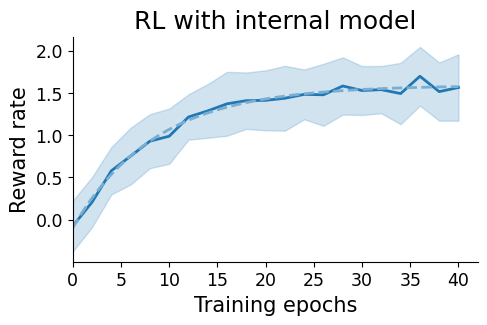

In [3]:
agent, fig = manager.inspect_agent(key)

# Find trained agents

We can find all trained agents for a given environment assumption (environment class and parameter, as well as the subjective reward discount and exploration tendency), but with different random seeds. `find_agents` will return agent keys ordered according to their testing performance.

4 agents found.
Plotting the existing best agent '1B39B3D3' for environment parameter:
[0.2, 0.05, 0.7, 0.1, 10.0, -1.0, 0.1]


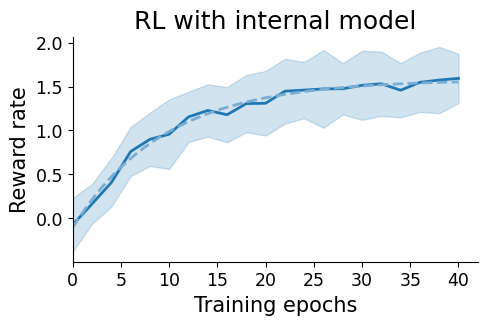

In [4]:
keys = manager.find_agents(env_param)
print(f"{len(keys)} agents found.")
key = keys[0]
print(f"Plotting the existing best agent '{key}' for environment parameter:\n{env_param}")
agent, fig = manager.inspect_agent(key)

# Run an agent

Next we run this agent in an environment different from its assumption. In fact, we will use an environment in which the boxes are not coupled, therefore the coupling parameter $p_\mathrm{couple}$ becomes a parameter of agent's superstition.
At each step, we can also query the agents belief about environment states (with respect to its own assumption). In the two-boxes example below, probabilities of all four possible food availabilty states will be plotted.

In [5]:
from irc.examples import IdenticalBoxesEnv

env = IdenticalBoxesEnv(
    p_appear=0.2, p_vanish=0.05, p_cue=0.6,
)
print(f'Real environment parameter: {env.get_param()}')
print(f'Assumed environment parameter: {agent.model.env.get_param()}')

episode = agent.run_one_episode(env=env, max_steps=60)

Real environment parameter: [ 0.2   0.05  0.6   0.1  10.   -1.  ]
Assumed environment parameter: [ 0.2   0.05  0.7   0.1  10.   -1.    0.1 ]


Plot believed probabilities of all four food availability combinations


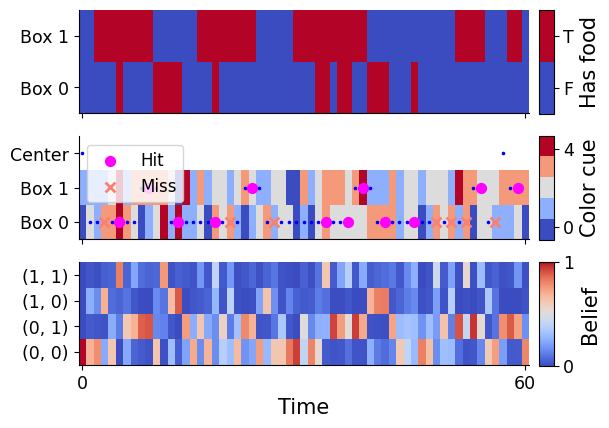

Plot believed marginal probability of two boxes


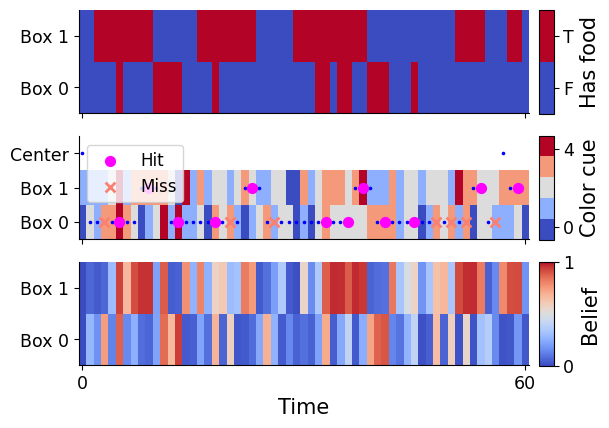

In [6]:
from boxforage.utils import plot_episode

print('Plot believed probabilities of all four food availability combinations')
fig = plot_episode(episode)

plt.show()

print('Plot believed marginal probability of two boxes')
fig = plot_episode(episode, plot_marginal=True)

# Train a family of agents defined over a parameter grid

To infer the assumed environment from agent behavior, we first need to prepare a family of agents whose assumed environment parameters are defined by a grid.

A parameter grid with various $p_\mathrm{appear}$, $p_\mathrm{cue}$ and the coupling parameter $p_\mathrm{couple}$ are prepared in `param_grids/coupled_boxes.yaml`.

In [7]:
param_grid = 'param_grids/coupled_boxes.yaml'
max_seed = 3 # number of random seeds for agent training

The snippet above can also be run from command line via `sweep-agent-grid.py`. Use command line arguments `count` and `num_epochs` to specify the number of agents to be trained, and the number of epochs to train.

During or after the sweeping over parameter grid, we can check the overall training progress by `overview_agents` method.

# Distill an agent from trained ones

After training enough number of rational agents with different assumptions about the environment, we can obtain a master agent that takes environment parameters as input by distillation.

In [8]:
d_agent, train_stats = manager.distill_agents_on_grid(
    param_grid, seeds=list(range(6)), to_train='', save_path='wukong.pt',
)

None of {'I', 'U', 'P'} is contained in `to_train`, skipping distillation.


Distillation can also be run from command line via `distill-agents.py`.

We can run the distilled agent to get episode data.

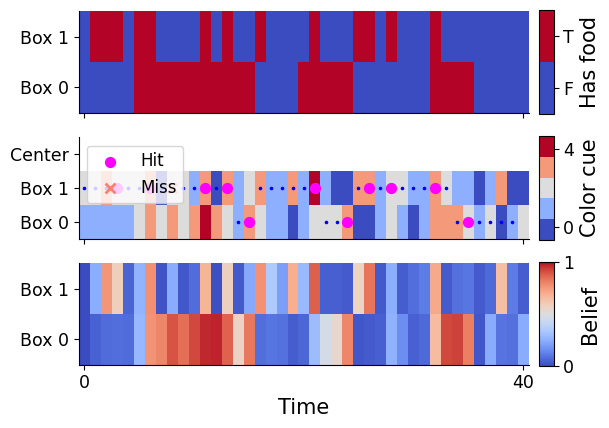

In [9]:
d_agent.set_env_param(env_param)
fig = plot_episode(d_agent.run_one_episode(), plot_marginal=True)

## Verify distilled agent

We can compare the distilled agent with individually trained one. Specifically, comparing the belief updates and action policies for data from a same episode.

Comparing state beliefs


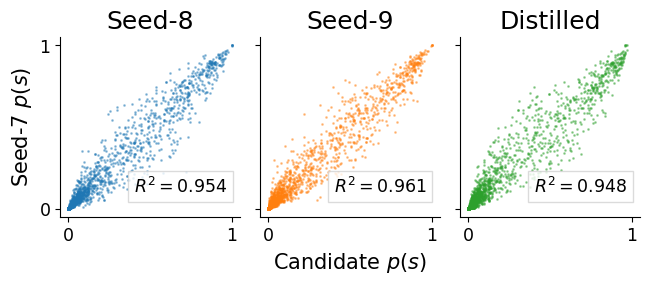

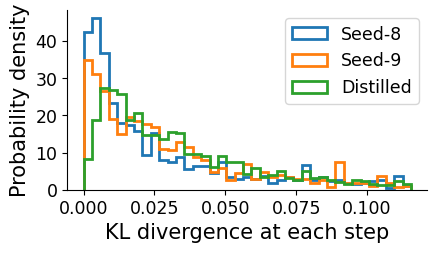

Comparing action policy


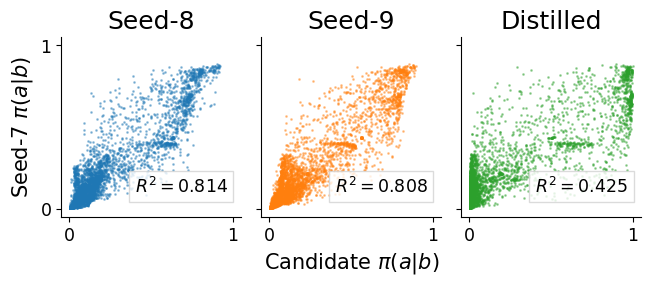

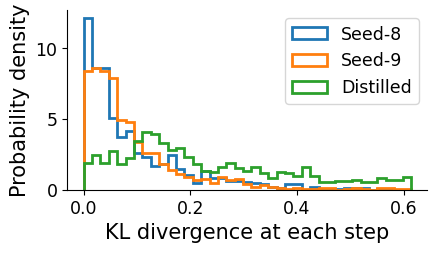

In [10]:
from irc.utils import plot_probs_scatter, plot_probs_kl_hist

# find agents that are not used for training
cond = {
    'seed': lambda x: x>=6,
    'task.ent_coef': 0.1,
}
agents, configs = map(list, zip(*sorted([
    manager._fetch_agent_by_key(key)
    for key in manager.find_agents([0.1, 0.05, 0.65, 0.1, 10., -1., 0], min_epoch=30, cond=cond)
], key=lambda x: x[1].seed)))
shared, diffs = manager.configs.compare(configs)
# use the first one as target agent, and the rest as candidate agents
t_agent = agents[0]
c_agents = agents[1:]
states = t_agent.model.p_s._all_xs.numpy()
# set environment parameter and subjective parameter to match
d_agent.set_env_param(shared.env_param, shared.task.gamma, shared.task.ent_coef)
agent_names = ['Seed-{:d}'.format(config.seed) for config in configs]+['Distilled']

# get episode data run by target agent, and compute state beliefs and action policy for other agents
_, state_probs, action_probs = manager.compare_agents(
    states, t_agent, c_agents+[d_agent], total_steps=1000, max_steps=50,
)

print('Comparing state beliefs')
fig = plot_probs_scatter(state_probs, xlabel='Candidate $p(s)$', ylabel=f'{agent_names[0]} $p(s)$', titles=agent_names[1:])
fig = plot_probs_kl_hist(state_probs, num_bins=40, labels=agent_names[1:])

plt.show()

print('Comparing action policy')
fig = plot_probs_scatter(action_probs, xlabel='Candidate $\pi(a|b)$', ylabel=f'{agent_names[0]} $\pi(a|b)$', titles=agent_names[1:])
fig = plot_probs_kl_hist(action_probs, num_bins=40, labels=agent_names[1:])

# Estimate agent assumption from behavior data

For a trained agent, we can calculate the likelihood of behavior data $\{o_{[0, T)}, a_{[0, T)}\}$ by first computing the belief traces
$$b_{[0, T)} = B\left(o_{[0, T)}, a_{[0, T)}\right)$$
and then use the agent policy $\pi(a|b)$ to get
$$ P = \prod_{t\in[0, T)} \pi(a_t|b_t)$$

Using the distilled agent, we can query the likelihood of data conditioned on different environment parameters. In the example below, we compute over a range of $p_\mathrm{appear}$, $p_\mathrm{cue}$ and $p_\mathrm{couple}$, while assuming the rest of environment parameters as ground truth. The estimated environment parameter is close to the ground truth, shown by an animation `env-param-likelihood.gif`.

In [11]:
p_appear = np.linspace(0.05, 0.3, 40)
p_cue = np.linspace(0.6, 0.9, 50)
p_couple = np.linspace(-0.5, 0.5, 50)

env_param_gt = env_param
i_gt = np.argmin(np.abs(p_appear-env_param_gt[0]))
j_gt = np.argmin(np.abs(p_cue-env_param_gt[2]))
k_gt = np.argmin(np.abs(p_couple-env_param_gt[6]))

In [12]:
data_logps = np.zeros((len(p_appear), len(p_cue), len(p_couple)))
for i in range(len(p_appear)):
    for j in range(len(p_cue)):
        for k in range(len(p_couple)):
            env_param = [*env_param_gt]
            env_param[0] = p_appear[i]
            env_param[2] = p_cue[j]
            env_param[6] = p_couple[k]
            
            d_agent.set_env_param(env_param)
            beliefs, logps = d_agent.compute_likelihoods(episode['observations'], episode['actions'])
            data_logps[i, j, k] = logps.sum().item()
i_max, j_max, k_max = (data_logps==data_logps.max()).nonzero()

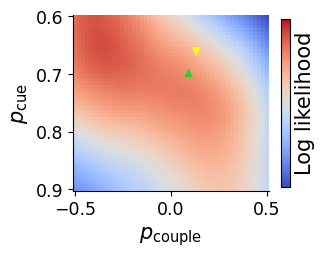

In [13]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(3.5, 3))
ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
dx = p_couple[1]-p_couple[0]
xlim = [p_couple.min()-dx/2, p_couple.max()+dx/2]
dy = p_cue[1]-p_cue[0]
ylim = [p_cue.max()+dy/2, p_cue.min()-dy/2]
h = ax.imshow(
    data_logps[0], aspect=3, extent=[*xlim, *ylim],
    vmin=data_logps.min(), vmax=data_logps.max(), cmap='coolwarm',
)
marker_size = 40
sc_gt = ax.scatter(p_couple[k_gt], p_cue[j_gt], s=marker_size, color='limegreen', marker='^', edgecolor='none')
sc_max = ax.scatter(p_couple[k_max], p_cue[j_max], s=marker_size, color='yellow', marker='v', edgecolor='none')
plt.colorbar(h, shrink=0.8, ticks=[], label='Log likelihood')
title = ax.set_title('')
xlabel = ax.set_xlabel(r'$p_\mathrm{couple}$')
ylabel = ax.set_ylabel(r'$p_\mathrm{cue}$')
fig.savefig('test-bbox.png')
plt.show()

In [14]:
def update(i):
    sigma = 2
    h.set_data(data_logps[i])
    title.set_text(r'$p_\mathrm{appear}$='+'{:.2f}'.format(p_appear[i]))
    sc_gt.set_alpha(np.exp(-((i-i_gt)/sigma)**2))
    sc_max.set_alpha(np.exp(-((i-i_max)/sigma)**2))
    return h, title, sc_gt, sc_max

ani = FuncAnimation(fig, update, frames=range(len(data_logps)), blit=True)
ani.save('env-param-likelihood.gif', dpi=600)

MovieWriter ffmpeg unavailable; using Pillow instead.
